In [549]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [550]:
import numpy as np
import pandas as pd

In [551]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [552]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [553]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [554]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [555]:
# We can view all of the classes that automap found
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [556]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement


In [557]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [558]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
query = session.query(measurement).filter_by(date='2016-08-23')
m  =query.first()
id = m.id

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date, measurement.prcp).filter(id>= id)
results = query.all()
# print(results)
# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(results, columns=['Date', 'Prcp'])
# Sort the dataframe by date
data = data.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
# data.plot(kind='bar')

In [559]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,Prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [560]:
# Design a query to show how many stations are available in this dataset?
query = session.query(station)
m = query.all()
query.count()

9

In [561]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.id,measurement.station,func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id)).all()

[(9008, 'USC00518838', 511),
 (7636, 'USC00517948', 1372),
 (14960, 'USC00511918', 1979),
 (5434, 'USC00514830', 2202),
 (16939, 'USC00516128', 2612),
 (9519, 'USC00519523', 2669),
 (2725, 'USC00513117', 2709),
 (1, 'USC00519397', 2724),
 (12188, 'USC00519281', 2772)]

In [562]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station=='USC00519281')
query.first()

(54.0, 85.0, 71.66378066378067)

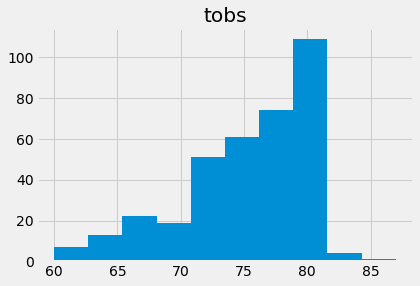

In [563]:
# Choose the station with the highest number of temperature observations.
query1 = session.query(func.max(measurement.tobs))
query1.first()

query = session.query(measurement.station).filter(measurement.tobs == 87.0)
query.first()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query2 = session.query(measurement.date,measurement.tobs).filter(measurement.station == 'USC00519397', measurement.date>='2016-08-23')
data = query2.all()

df = pd.DataFrame(data, columns=['date','tobs'])
df.hist()

plt.show()

## Bonus Challenge Assignment

In [564]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [565]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


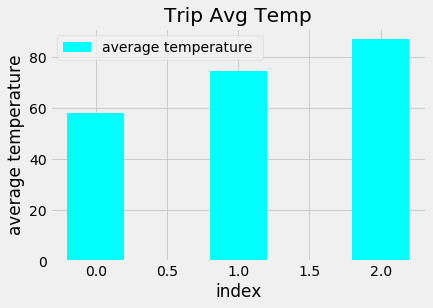

In [566]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = np.arange(0,3,1)
y =[58.0, 74.59058295964125, 87.0]   
xe = 0.1 * np.abs(np.random.randn(len(y)))  #通过标准正态分布得出误差值
#将误差值赋值给yerr这个属性
plt.bar(x,y,yerr = xe, width = 0.4, align = 'center', ecolor = 'r', color = 'cyan', label = 'average temperature ')
        
plt.xlabel('index')     #x轴标签
plt.ylabel('average temperature')   #y轴标签
plt.title('Trip Avg Temp')        #题目
plt.legend(loc = 'upper left')  #图例放置的位置

In [567]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query = session.query(measurement.station,station.latitude, station.longitude,station.elevation,func.sum(measurement.tobs)).filter(measurement.date >= "2016-08-23",measurement.date <= "2017-08-23").group_by(measurement.station).join(station, measurement.station == station.station)
query.all()

[('USC00513117', 21.4234, -157.8015, 14.6, 25134.0),
 ('USC00514830', 21.5213, -157.8374, 7.0, 23534.0),
 ('USC00516128', 21.3331, -157.8025, 152.4, 25160.0),
 ('USC00517948', 21.3934, -157.9751, 11.9, 13685.0),
 ('USC00519281', 21.45167, -157.84888999999998, 32.9, 25734.0),
 ('USC00519397', 21.2716, -157.8168, 3.0, 27151.0),
 ('USC00519523', 21.33556, -157.71139, 19.5, 25939.0)]

In [568]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [569]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2017-08-16"
end_date = "2017-08-23"
# Use the start and end date to create a range of dates
date = session.query(measurement.date).filter(measurement.date >= "2017-08-16",measurement.date <= "2017-08-23").all()
# Stip off the year and save a list of %m-%d strings
date = [i[0] for i in date]
date = ["{}-{}".format(i.split("-")[1],i.split("-")[2]) for i in date]
date = list(set(date))
normals = []
# Loop through the list of %m-%d strings and calculate the normals for each date
for i in date:
    normals.append(daily_normals(i)[0])
print(normals)

[(70.0, 76.92307692307692, 84.0), (67.0, 76.6923076923077, 87.0), (68.0, 76.45283018867924, 82.0), (69.0, 76.47169811320755, 84.0), (67.0, 76.4, 83.0), (69.0, 76.08, 83.0), (69.0, 76.125, 83.0), (69.0, 75.94642857142857, 85.0)]


In [570]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['min', 'avg', 'max'],index=pd.date_range(start='2017-08-16', end='2017-08-23',
                       freq='d'))


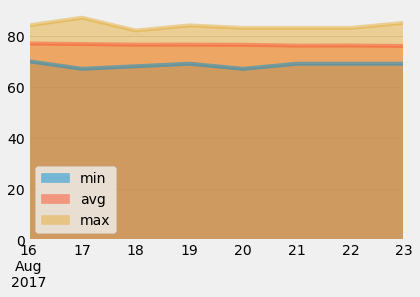

In [571]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(alpha = 0.5, stacked=False)